In [1]:
import os
import time
import copy
import random
import numpy as np
import math
import pandas as pd
import torch.utils.data as data_utils
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

from IPython.display import Audio, display
def allDone():
    urL = 'https://www.wavsource.com/snds_2020-10-01_3728627494378403/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
# allDone()

seedy = 666
random.seed(seedy)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

### <font color=orange> Load data.

In [2]:
train_motifs = np.genfromtxt('data_dev/LEGACY/train_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data_dev/LEGACY/train_motifxFamMatrix.csv',delimiter=',',dtype=int)
test_motifs = np.genfromtxt('data_dev/LEGACY/new_test_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data_dev/LEGACY/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data_dev/fams.csv',dtype='U')
X_train, X_val = train_test_split(range(len(train_motifs)), test_size=0.2, random_state=666)
print(len(X_train), len(X_val))

5159 1290


In [3]:
AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'
def get_oneHot_motifs(motifs, AMINOS=AMINOS):
    oneHot_motifs = []
    for motif in motifs:
        one_hotted = np.zeros((len(motif), len(AMINOS)),dtype=float)
        for i,aa in enumerate(motif):
            hot = AMINOS.find(aa)
            one_hotted[i][hot] = 1
        oneHot_motifs.append(one_hotted)
    oneHot_motifs = np.asarray(oneHot_motifs)
    oneHot_motifs = np.swapaxes(oneHot_motifs,1,2)
    return oneHot_motifs

In [4]:
# # # # # # # #
my_embed = '02' 
# # # # # # # #

#############################################
# Get Siamese embedding coords.
#############################################

embedding = np.genfromtxt('MODELS_siam/LEGACY/emb_%s_embedding.csv' % my_embed,delimiter=',',dtype=float)
train_embedding = embedding[ :len(train_motifs) ]
test_embedding = embedding[ len(train_motifs): ]
print(embedding.shape)

(7302, 100)


In [5]:
#############################################
# Get fam distance matrix for Phylo MSE loss.
#############################################

all_fams = (np.genfromtxt('data_dev/fam_distances_blos62/fams.csv',dtype='U'))
dist_matrix = (np.genfromtxt('data_dev/fam_distances_blos62/dist_matrix.csv',delimiter=',',dtype=float))

fam_idc = [np.where(all_fams==fam)[0][0] for fam in fams]
fam_dist_matrix = dist_matrix[fam_idc][:,fam_idc]
        
# normalize fam distances
fMax = np.max(fam_dist_matrix)
fMin = np.min(fam_dist_matrix)

fam_dist_matrix_scaled = np.array((fam_dist_matrix))
for i in range(len(fams)):
    for j in range(len(fams)):
        fam_dist_matrix_scaled[i][j] = 1 - float(fam_dist_matrix[i][j]-fMin)/(fMax-fMin) 
fam_dist_matrix = fam_dist_matrix_scaled

# import seaborn as sb
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# heat_map = sb.heatmap(fam_dist_matrix_scaled, annot=True, cmap="spring", fmt='1.2f',
#                       square=True, yticklabels=fams, xticklabels=fams, vmin=0.0 )
# plt.show()

famDistMatrix = fam_dist_matrix

In [6]:
def get_stacked_features(motifs, embeddings):
    oneHot_motifs = get_oneHot_motifs(motifs)
    squished_oneHots = oneHot_motifs.reshape(oneHot_motifs.shape[0],oneHot_motifs.shape[1]*
                                         oneHot_motifs.shape[2])
    stacked_features = np.hstack((squished_oneHots,embeddings))
    stacked_features = torch.tensor(stacked_features)
    return stacked_features        

In [7]:
# print("motifs:",get_oneHot_motifs(test_motifs).shape,22*15)
# print("embeds:",test_embedding.shape)
# print("stacked:",get_stacked_features(test_motifs,test_embedding).shape)

### <font color=orange> Cannot used stratified K fold because I have multi-label data ... Will try a thing from stackoverflow.

In [8]:
## https://stats.stackexchange.com/questions/65828/
## how-to-use-scikit-learns-cross-validation-functions-on-multi-label-classifiers

def proba_mass_split(y, folds=5):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
#     print("Fold distributions are")
    return index_list

np.random.seed(seedy)
folds = proba_mass_split(train_motifxFamMatrix)

In [9]:
def get_microROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(fams)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
    return auc(fpr_micro, tpr_micro)

def get_macroAP(y_test, y_score): ### 'macro' means each class is weighted evenly. ###
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(fams)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    return average_precision_score(y_test, y_score, average="macro")

In [10]:
def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs, stopper='loss', 
                version='seq-coord', this_loss='phylo',mat_kind='0',operator='BCE',power=1.0,
                my_reduction='sum'):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    running = - math.inf
    current = running
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        
        print("Epoch",epoch+1)
        for phase in ['train','validate']:
            running_loss = 0.0
            running_acc = 0.0
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
            for inputs,labels in loader:
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                motif = inputs[:,:-embedding.shape[1]].reshape( batch_size, len(AMINOS), len(train_motifs[0]) )
                coords = inputs[:,-embedding.shape[1]:]

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model.forward(motif, coords, version)
                    if this_loss=='phylo' and version=='seq-coord':
                        loss = phylo_error(outputs,labels,mat_kind,operator,power,my_reduction)
                    elif this_loss!='phylo':
                        criterion = nn.BCELoss() # BCE loss is the usual loss to use.
                        loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()

                y_test = np.asarray(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                acc = get_microROC(y_test, y_score)
                running_acc += acc
            
            loss = running_loss / len(loader) 
            acc =  running_acc / len(loader) 
            
            if phase=='train':
                train_losses.append(loss)
                train_accs.append(acc)
                
            elif phase=='validate':
                val_losses.append(loss)
                val_accs.append(acc)
                
                if stopper=='loss':
                    current = -loss
                elif stopper=='acc':
                    current = acc
                elif stopper=='epoch':
                    current = epoch
                if current >= running:
                    running = current
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
            print("~ %s LOSS: %5.3f | ACC: %5.3f" % (phase,loss,acc))
            if current >= running and phase=='validate':
                print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_losses, train_accs, val_losses, val_accs)

In [11]:
def get_loader(motifs,embedding,motifxFamMatrix,idc,my_batch):
    these_motifs = motifs[idc]
    this_embedding = embedding[idc]
    X = get_stacked_features(these_motifs,this_embedding)
    Y = torch.tensor(motifxFamMatrix[idc])
    dataset = data_utils.TensorDataset(X, Y)
    loader = data_utils.DataLoader(dataset, batch_size=my_batch, shuffle=True, drop_last=True)
    return loader

In [ ]:
#         #### MOTIF NET ####
#         self.conv1 = nn.Conv1d(22, 16, kernel_size=5, padding=2)
#         self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
#         self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
#         self.pool = nn.MaxPool1d(2)
#         self.penult = nn.Linear(64, 32)

#         #### COORD NET ####
#         self.mlp1 = nn.Linear(embedding.shape[1], 112)
#         self.bn1 = nn.BatchNorm1d(112)
#         self.mlp2 = nn.Linear(112, 96)
#         self.bn2 = nn.BatchNorm1d(96)
#         self.mlp3 = nn.Linear(96, 64)
#         self.bn3 = nn.BatchNorm1d(64)
#         self.penult = nn.Linear(64, 32)

#         ### CAT LAYERS ###
#         self.penult = nn.Linear(64, 32)
#         self.out = nn.Linear(32, len(fams))
#         self.sigmoid = nn.Sigmoid()

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self,conv_drpt=0.0,mlp_drpt=0.0):
        super(Model, self).__init__()

        #### MOTIF NET ####
        self.conv1 = nn.Conv1d(22, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.penult = nn.Linear(64, 32)

        #### COORD NET ####
        self.mlp1 = nn.Linear(embedding.shape[1], 112)
        self.bn1 = nn.BatchNorm1d(112)
        self.mlp2 = nn.Linear(112, 96)
        self.bn2 = nn.BatchNorm1d(96)
        self.mlp3 = nn.Linear(96, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.penult = nn.Linear(64, 32)

        ### CAT LAYERS ###
        self.penult = nn.Linear(64, 32)
        self.out = nn.Linear(32, len(fams))
        self.sigmoid = nn.Sigmoid()

        #### MISC LAYERS ####
        self.relu = nn.ReLU()
        self.conv_drpt = nn.Dropout(p = conv_drpt)
        self.mlp_drpt = nn.Dropout(p = mlp_drpt)
        self.ablate = nn.Dropout(p = 1.0)

    def forward(self, oneHot_motif, coords, version='seq-coord'):
        #### MOTIF NET ####
        conv1 = self.conv1(oneHot_motif.float())
        conv1 = self.relu(conv1)
        conv1 = self.pool(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.relu(conv2)
        conv2 = self.pool(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.relu(conv3)
        conv3 = self.pool(conv3)
        seq_out = conv3.view(conv3.size()[0], -1)
        seq_out = self.penult(seq_out) ## SEQ PENULT
        seq_out = self.relu(seq_out)
        seq_out = self.conv_drpt(seq_out)

        #### COORD NET ####
        mlp1 = self.mlp1(coords)
        mlp1 = self.relu(mlp1)
        mlp1 = self.bn1(mlp1)
        mlp1 = self.mlp_drpt(mlp1)
        mlp2 = self.mlp2(mlp1)
        mlp2 = self.relu(mlp2)
        mlp2 = self.bn2(mlp2)
        mlp2 = self.mlp_drpt(mlp2)
        mlp3 = self.mlp3(mlp2)
        mlp3 = self.relu(mlp3)
        mlp3 = self.bn3(mlp3)
        mlp3 = self.mlp_drpt(mlp3)
        coord_out = self.penult(mlp3)
        coord_out = self.relu(coord_out)

        
        
        
        if version=='seq-coord':
            seq_out = self.conv_drpt(seq_out) # seqCoord version
        else:
            seq_out = self.ablate(seq_out) # seq-only version
        
        coords_out = self.mlp_drpt(coord_out)
        
        
        
        
        cat = torch.cat((seq_out,coords_out), 1)
        cat = self.penult(cat)
        out = self.out(cat)
        out = self.sigmoid(out)
        
        return out

In [68]:
def phylo_error(output, target, mat_kind='0', operator='BCE',power=1.0,my_reduction='sum'):
        
    weights = np.ones((output.shape[0],output.shape[1]))

    for i,t in enumerate(target):
        t = t.cpu()
        wIdc = np.where(t.detach().numpy()==1)[0]

        if len(wIdc)==0:
            weights[i] = 0.000001
            continue
        theseWeights = np.ones((len(fams)))
        
        # want inter-fam weights to be distance (larger number, less related = more weight) ?
        # want intra-fam weights to be similarity (larger number = more weight) ?
        for wIdx in wIdc:
            if mat_kind=='0':
                thisWeight = 1.00 - famDistMatrix[wIdx].copy() # inter-fam
                thisWeight[wIdx] =  famDistMatrix[wIdx][wIdx].copy() # intra-fam
            elif mat_kind=='1':
                thisWeight = famDistMatrix[wIdx].copy() # inter-fam
                thisWeight[wIdx] =  1.00 - famDistMatrix[wIdx][wIdx].copy() # intra-fam

            theseWeights+=thisWeight # add to existing list of fam distances, respectively (element wise)
            
        fWeight = theseWeights/len(fams) # take median / average
        weights[i] = fWeight 
    weights = torch.tensor(weights)
    weights = weights.to(device)
    
    if operator=='MSE':
        crit = nn.MSELoss()
        answer = crit(output, target) * weights.mean().float()
    
    elif operator=='BCE':
        crit = nn.BCELoss(reduction=my_reduction)
        answer = crit(output, target) * weights.mean().float()

    return answer

In [ ]:
s = time.time()

my_version = 'seq-coord'         # seq-coord OR seq
my_loss = 'phylo'            # phylo OR canon

# ONLY IF DOING PHYLO LOSS
operator='BCE'
mat_kind='0'
power=1.0
my_reduction = 'sum' # mean OR sum

my_conv_drpt = 0.0 # seq dropout
my_mlp_drpt = 0.2 # coord dropout

my_stopper = 'acc'
my_batch = 32
my_epochs = 25
my_lr = 0.0015

all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

all_best_runs = []
all_models = []

for i,fold in enumerate(folds):
    
    print("\n* * * * * * * * FOLD %d * * * * * * * *\n" %(i+1))
    
    fold_val_idc = fold
    fold_train_idc = [x for x in range(len(train_motifs)) if x not in fold_val_idc]
    
    train_loader = get_loader(train_motifs,train_embedding,train_motifxFamMatrix,fold_train_idc,my_batch)
    val_loader = get_loader(train_motifs,train_embedding,train_motifxFamMatrix,fold_val_idc,my_batch)
    
    model = Model(my_conv_drpt,my_mlp_drpt)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(),lr = my_lr)
    
    (best_run, best_model, train_losses, train_accs, val_losses, val_accs) = \
                    train_model(train_loader, val_loader,
                                model, optimizer,my_batch, 
                                my_epochs,my_stopper,my_version,
                                my_loss, mat_kind,operator,power)
    
    all_best_runs.append(best_run)
    all_models.append(best_model)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)


* * * * * * * * FOLD 1 * * * * * * * *

Epoch 1


/home/k4thryn/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


~ train LOSS: 11.184 | ACC: 0.868
~ validate LOSS: 12.689 | ACC: 0.833
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 8.531 | ACC: 0.922
~ validate LOSS: 12.306 | ACC: 0.858
      BEST SO FAR ^ ^ ^
Epoch 3
~ train LOSS: 8.322 | ACC: 0.926
~ validate LOSS: 19.960 | ACC: 0.736
Epoch 4
~ train LOSS: 8.210 | ACC: 0.927
~ validate LOSS: 11.899 | ACC: 0.826
Epoch 5
~ train LOSS: 8.214 | ACC: 0.928
~ validate LOSS: 8.686 | ACC: 0.919
      BEST SO FAR ^ ^ ^
Epoch 6
~ train LOSS: 7.996 | ACC: 0.932
~ validate LOSS: 22.553 | ACC: 0.741
Epoch 7
~ train LOSS: 7.977 | ACC: 0.932
~ validate LOSS: 11.257 | ACC: 0.859
Epoch 8
~ train LOSS: 7.773 | ACC: 0.936
~ validate LOSS: 17.497 | ACC: 0.759
Epoch 9
~ train LOSS: 7.701 | ACC: 0.936
~ validate LOSS: 14.103 | ACC: 0.808
Epoch 10
~ train LOSS: 7.552 | ACC: 0.940
~ validate LOSS: 7.548 | ACC: 0.937
      BEST SO FAR ^ ^ ^
Epoch 11
~ train LOSS: 7.492 | ACC: 0.940
~ validate LOSS: 9.241 | ACC: 0.903
Epoch 12
~ train LOSS: 7.336 | ACC: 0.943
~ validate L

In [45]:
print("TIME: %5.3f mins" % ((time.time()-s)/60))
print("BEST RUNS:",all_best_runs)

TIME: 6.193 mins
BEST RUNS: [15, 10, 19, 7, 9]


In [46]:
# # # # # # # # # # # #
run = '31'
# # # # # # # # # # # #

if not os.path.exists("MODELS_multiclass/LEGACY/%s/" % run):
    os.makedirs("MODELS_multiclass/LEGACY/%s/" % run)
for i,model_weights in enumerate(all_models):
    torch.save(model_weights, "MODELS_multiclass/LEGACY/%s/%d_weights" % (run,i))

In [47]:
all_train_losses_arr = np.zeros(my_epochs)
all_train_accs_arr = np.zeros(my_epochs)
all_val_losses_arr = np.zeros(my_epochs)
all_val_accs_arr = np.zeros(my_epochs)

for i in range(my_epochs):
    all_train_losses_arr[i] = sum([all_train_losses[j][i] for j in range(len(folds))]) / len(folds)
    all_train_accs_arr[i] = sum([all_train_accs[j][i] for j in range(len(folds))]) / len(folds)
    all_val_losses_arr[i] = sum([all_val_losses[j][i] for j in range(len(folds))]) / len(folds)
    all_val_accs_arr[i] = sum([all_val_accs[j][i] for j in range(len(folds))]) / len(folds)
    
if my_reduction=='sum':
    all_train_losses_arr=all_train_losses_arr*.005
    all_val_losses_arr=all_val_losses_arr*.005

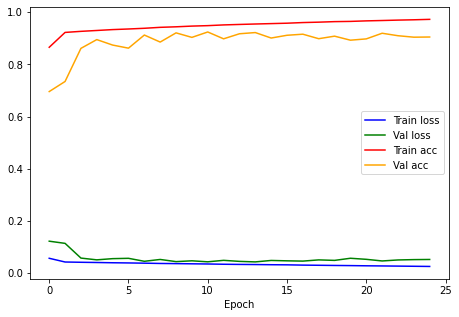

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7.5,5))

plt.plot(all_train_losses_arr,label='Train loss',c='blue')
plt.plot(all_val_losses_arr,label='Val loss',c='green')
plt.plot(all_train_accs_arr,label='Train acc',c='red')
plt.plot(all_val_accs_arr,label='Val acc',c='orange')

plt.xlabel("Epoch")
plt.legend(loc='center right')
plt.savefig("FIGS_multiclass/LEGACY/" + run + "_loss-acc")

plt.show()

In [49]:
def eval_model(model, thresh=0.5):
    
    model.eval()
    loader = get_loader(test_motifs,test_embedding,test_motifxFamMatrix,range(len(test_motifs)),len(test_motifs))
    
    for inputs, labels in loader:
        
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        motif = inputs[:,:-embedding.shape[1]].reshape( len(test_motifs), len(AMINOS), len(train_motifs[0]) )
        coords = inputs[:,-embedding.shape[1]:]
        
        outputs = model.forward(motif, coords, my_version)
        
        accuracy = 0
        totTrues = 0
        for i,out in enumerate(outputs):
            pred = np.where(out.cpu().detach().numpy() > thresh)[0]
            true = np.where(labels.data.cpu()[i]==1)[0]
            totTrues += len(true)
            accuracy += len(pred)

        y_score = outputs.cpu().detach().numpy()
        y_test = np.asarray(labels.cpu())
                
        return y_test, y_score

In [50]:
# run = '??'

# all_y_scores = []
# all_y_test = []
# for i in range(5):
    
#     model = Model()
#     model = model.to(device)
#     model.load_state_dict(torch.load("MODELS_multiclass/%s/%d_weights" % (run,i)))
    
#     y_test, y_score = eval_model(model)
#     all_y_scores.extend(y_score)
#     all_y_test.extend(y_test)
    
# y_score = np.asarray(all_y_scores)
# y_test = np.asarray(all_y_test)

In [51]:
all_y_scores = []
all_y_test = []
for model_weights in all_models:
    
    model = Model()
    model = model.to(device)
    model.load_state_dict(model_weights)
    
    y_test, y_score = eval_model(model)
    all_y_scores.extend(y_score)
    all_y_test.extend(y_test)
    
y_score = np.asarray(all_y_scores)
y_test = np.asarray(all_y_test)

In [52]:
## ROC

from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

FAM_IDC = [x for x in range(len(fams))]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [53]:
## PRECISION-RECALL

from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score, average="macro")

In [54]:
# import warnings
# warnings.filterwarnings('ignore')
# from classifierNet import Model

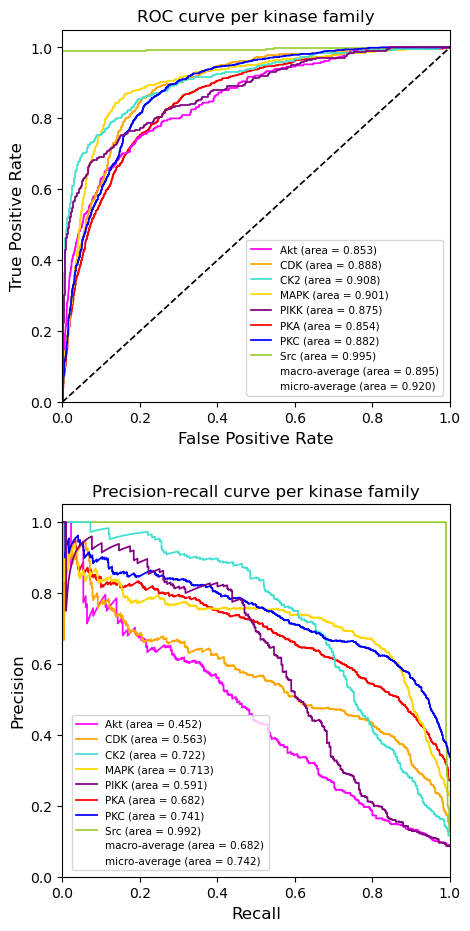

In [55]:
from itertools import cycle
import matplotlib.pyplot as plt

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
lw = 1.25

############################################################
###################  AUROC #################################
############################################################

colors = cycle(['red','magenta','orange', 'gold','yellowgreen','turquoise', 'blue', 'purple']) 
lines = []
labels = []

l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(roc_auc["micro"]))
l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(roc_auc["macro"]))

for i, color in zip( range( len(fams) ), colors):
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'    
    l, = ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    labels.append('{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    lines.append(l)

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12) 
ax1.set_title('ROC curve per kinase family',fontsize=12) 
labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax1.legend(lines, labels, loc=(0.475, .0175), fontsize=7.5)  # (1.05, .0)

############################################################
###############  PRECISION-RECALL ##########################
############################################################

colors = cycle(['red','magenta','orange', 'gold','yellowgreen','turquoise', 'blue', 'purple']) 
lines = []
labels = []

l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(average_precision["micro"]))
l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(average_precision["macro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = ax2.plot(recall[i], precision[i], color=color, lw=lw)
    lines.append(l)
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'
    labels.append('{0} (area = {1:0.3f})'.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) 
ax2.set_ylabel('Precision',fontsize=12) 
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) 

labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax2.legend(lines, labels, loc=(0.025, .0175), fontsize=7.5) # (1.05, .0)

plt.savefig("FIGS_multiclass/LEGACY/%s_roc-prc" % run, bbox_inches='tight')
plt.show()

In [56]:
print("BEST RUNS:",all_best_runs,"\n")

print('AUROC macro: {0:0.3f}'.format(roc_auc["macro"]))
print('AUROC micro: {0:0.3f}'.format(roc_auc["micro"]))

print('\nAP macro: {0:0.3f}'.format(average_precision["macro"]))
print('AP micro: {0:0.3f}'.format(average_precision["micro"]))

BEST RUNS: [15, 10, 19, 7, 9] 

AUROC macro: 0.895
AUROC micro: 0.920

AP macro: 0.682
AP micro: 0.742


In [57]:
allDone()